<a href="https://colab.research.google.com/github/shrestha-khatri/Passenger-Detection/blob/main/perception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision matplotlib


In [ ]:
#Question 2

In [ ]:

!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip PennFudanPed.zip -d ./data

--2025-08-30 19:56:11--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  31.6MB/s    in 1.6s    

2025-08-30 19:56:13 (31.6 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: ./data/PennFudanPed/
  inflating: ./data/PennFudanPed/added-object-list.txt  
   creating: ./data/PennFudanPed/Annotation/
  inflating: ./data/PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: ./data/PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: ./data/PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: ./data/PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: ./data/PennFudanPed/Annotatio

In [ ]:
import os

print(os.listdir("./data/PennFudanPed"))


['Annotation', 'PNGImages', 'PedMasks', 'readme.txt', 'added-object-list.txt']


In [ ]:
import torch
import os
import numpy as np
from PIL import Image

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):

        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)


        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]


        masks = mask == obj_ids[:, None, None]


        boxes = []
        for m in masks:
            pos = np.where(m)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])


        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
        }

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
import torchvision
from torch.utils.data import DataLoader, random_split


to_tensor = torchvision.transforms.ToTensor()


dataset = PennFudanDataset("./data/PennFudanPed", transforms=to_tensor)


def collate_fn(batch):
    return tuple(zip(*batch))

# split 80% train, 20% val
torch.manual_seed(0)
n_total = len(dataset)
n_train = int(0.8 * n_total)
n_val = n_total - n_train
train_ds, val_ds = random_split(dataset, [n_train, n_val])


train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"Train images: {len(train_ds)} | Val images: {len(val_ds)}")


Train images: 136 | Val images: 34


In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

num_classes = 2


try:
    model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
except:
    model = fasterrcnn_resnet50_fpn(pretrained=True)


in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:01<00:00, 96.9MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=5e-4)


In [ ]:
epochs = 5

for epoch in range(1, epochs+1):
    model.train()
    running = 0.0
    for imgs, targets in train_loader:
        imgs = [im.to(device) for im in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


        loss_dict = model(imgs, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item()

    print(f"Epoch {epoch}/{epochs} | Train Loss: {running/len(train_loader):.4f}")


Epoch 1/5 | Train Loss: 0.2568
Epoch 2/5 | Train Loss: 0.1160
Epoch 3/5 | Train Loss: 0.0885
Epoch 4/5 | Train Loss: 0.0666
Epoch 5/5 | Train Loss: 0.0662


In [ ]:
import torch
print(torch.cuda.get_device_name(0))


Tesla T4


In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
Tesla T4


In [ ]:
!pip install scikit-learn

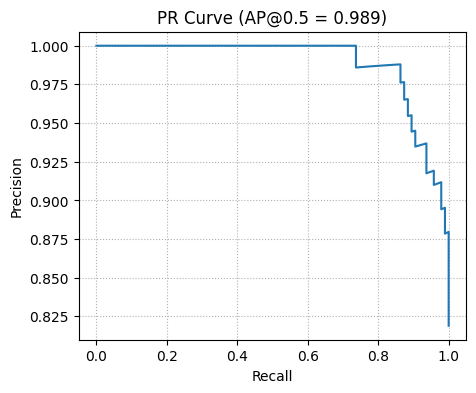

AP@0.5: 0.989


In [ ]:
!pip install scikit-learn
import numpy as np
import matplotlib.pyplot as plt
from torchvision.ops import box_iou
from sklearn.metrics import precision_recall_curve, average_precision_score

model.eval()
all_scores = []
all_is_tp  = []

with torch.no_grad():
    for imgs, targets in val_loader:
        img = imgs[0].to(device)
        tgt = {k: v.to(device) for k, v in targets[0].items()}

        out = model([img])[0]

        pred_boxes  = out["boxes"].detach().cpu()
        pred_scores = out["scores"].detach().cpu().numpy()
        gt_boxes    = tgt["boxes"].detach().cpu()


        is_tp = np.zeros(len(pred_boxes), dtype=int)
        if len(gt_boxes) > 0 and len(pred_boxes) > 0:
            ious = box_iou(pred_boxes, gt_boxes).numpy()
            matched_gt = np.zeros(len(gt_boxes), dtype=bool)


            order = np.argsort(-pred_scores)
            for idx in order:
                iou_row = ious[idx]
                j = iou_row.argmax()
                if iou_row[j] >= 0.5 and not matched_gt[j]:
                    is_tp[idx] = 1
                    matched_gt[j] = True

        all_scores.extend(list(pred_scores))
        all_is_tp.extend(list(is_tp))

all_scores = np.array(all_scores)
all_is_tp  = np.array(all_is_tp)

precision, recall, _ = precision_recall_curve(all_is_tp, all_scores)
ap = average_precision_score(all_is_tp, all_scores)

plt.figure(figsize=(5,4))
plt.plot(recall, precision)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"PR Curve (AP@0.5 = {ap:.3f})")
plt.grid(True, linestyle=":")
plt.show()

print("AP@0.5:", round(ap, 3))



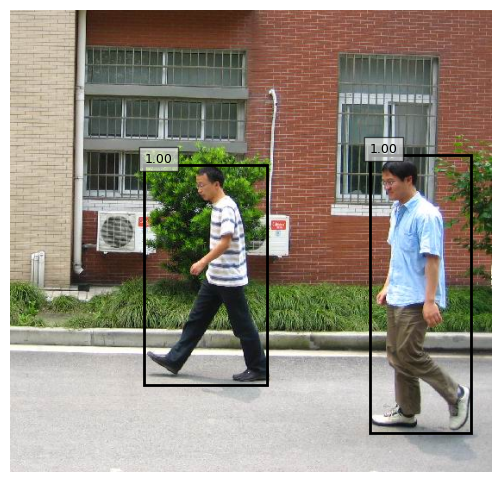

In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    img, _ = dataset[0]
    pred = model([img.to(device)])[0]

img_np = img.permute(1,2,0).numpy()

plt.figure(figsize=(7,6))
plt.imshow(img_np)
for (x1,y1,x2,y2), s in zip(pred["boxes"].cpu().numpy(), pred["scores"].cpu().numpy()):
    if s < 0.5:
        continue
    rect = plt.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(x1, y1-3, f"{s:.2f}", fontsize=9, bbox=dict(facecolor="white", alpha=0.6))
plt.axis("off")
plt.show()


In [ ]:
# Question 3 ( coordinate mapping )


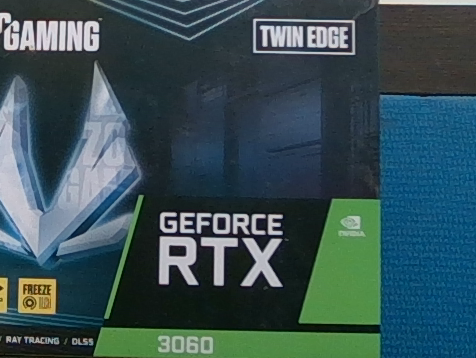

Cropped region: x=534, y=238, width=476, height=358


In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow


fx = 646.3569335937
fy = 645.5247192382
cx = 645.484069824
cy = 367.0691528320

points_3D = np.array([
    [-0.062, -0.079, 0.397],
    [ 0.218, -0.074, 0.388],
    [-0.066,  0.133, 0.384],
    [ 0.211,  0.133, 0.374]
])

def project_points(points, fx, fy, cx, cy):
    projected_points = []
    for X, Y, Z in points:
        u = (fx * X) / Z + cx
        v = (fy * Y) / Z + cy
        projected_points.append((int(u), int(v)))
    return projected_points


points_2D = project_points(points_3D, fx, fy, cx, cy)


u_coords = [p[0] for p in points_2D]
v_coords = [p[1] for p in points_2D]
x_min, x_max = min(u_coords), max(u_coords)
y_min, y_max = min(v_coords), max(v_coords)


img = cv2.imread("ques2_part1_image.png")

h, w = img.shape[:2]
x_min, y_min = max(0, x_min), max(0, y_min)
x_max, y_max = min(w-1, x_max), min(h-1, y_max)

crop = img[y_min:y_max, x_min:x_max]


cv2.imwrite("cropped.png", crop)
cv2_imshow(crop)

print(f"Cropped region: x={x_min}, y={y_min}, width={x_max-x_min}, height={y_max-y_min}")


In [ ]:
#Question 1

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imgA = cv2.imread("IMAGE_A.png", cv2.IMREAD_GRAYSCALE)
imgB = cv2.imread("IMAGE_B.png", cv2.IMREAD_GRAYSCALE)
imgC = cv2.imread("IMAGE_C.png", cv2.IMREAD_GRAYSCALE)


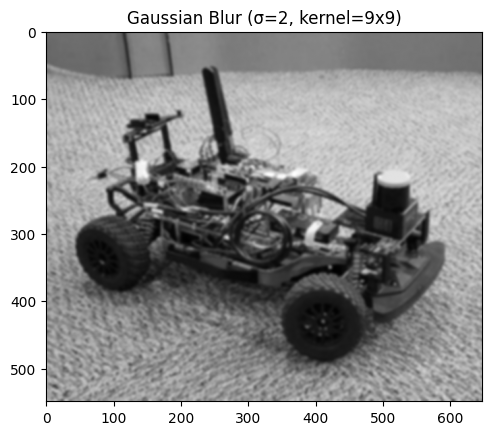

In [ ]:
# Gaussian Blur
gaussian_blur = cv2.GaussianBlur(imgA, (9, 9), sigmaX=2)

plt.imshow(gaussian_blur, cmap='gray')
plt.title("Gaussian Blur (σ=2, kernel=9x9)")
plt.show()


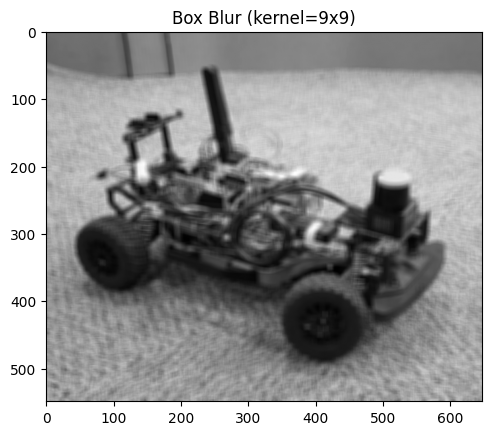

In [ ]:
# Box Blur
box_blur = cv2.blur(imgA, (9, 9))

plt.imshow(box_blur, cmap='gray')
plt.title("Box Blur (kernel=9x9)")
plt.show()


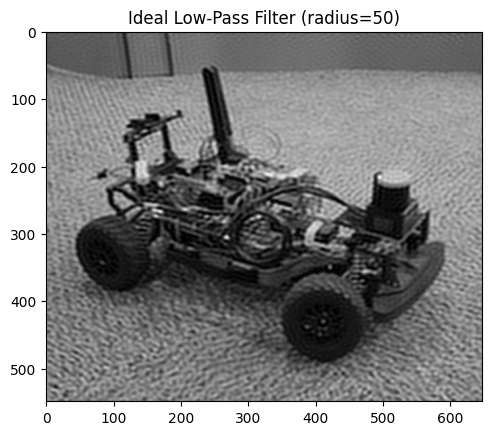

In [ ]:
f = np.fft.fft2(imgA)
fshift = np.fft.fftshift(f)

rows, cols = imgA.shape
crow, ccol = rows//2, cols//2
radius = 80

mask = np.zeros((rows, cols), np.uint8)
y, x = np.ogrid[:rows, :cols]
mask_area = (x-ccol)**2 + (y-crow)**2 <= radius*radius
mask[mask_area] = 1

fshift_filtered = fshift * mask


f_ishift = np.fft.ifftshift(fshift_filtered)
ideal_lpf = np.fft.ifft2(f_ishift)
ideal_lpf = np.abs(ideal_lpf)

plt.imshow(ideal_lpf, cmap='gray')
plt.title("Ideal Low-Pass Filter (radius=50)")
plt.show()


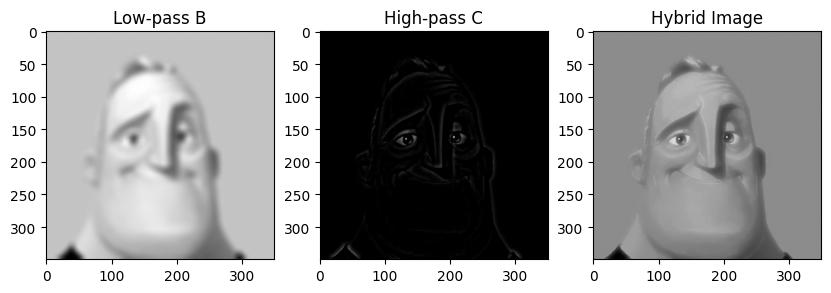

In [ ]:
imgB_low = cv2.GaussianBlur(imgB, (15,15), 5)

imgC_low = cv2.GaussianBlur(imgC, (15,15), 5)
imgC_high = cv2.subtract(imgC, imgC_low)

imgC_high = cv2.resize(imgB_high, (imgB_low.shape[1], imgB_low.shape[0]))

hybrid = cv2.add(imgB_low, imgC_high)

plt.figure(figsize=(10,5))
plt.subplot(1,3,1); plt.imshow(imgB_low, cmap='gray'); plt.title("Low-pass B")
plt.subplot(1,3,2); plt.imshow(imgC_high, cmap='gray'); plt.title("High-pass C")
plt.subplot(1,3,3); plt.imshow(hybrid, cmap='gray'); plt.title("Hybrid Image")
plt.show()


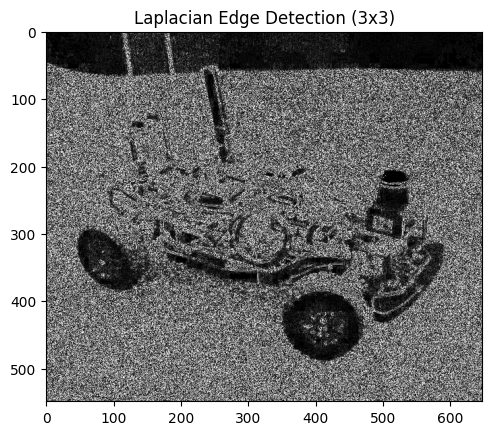

In [ ]:
# Laplacian Edge Detection
laplacian_edges = cv2.Laplacian(imgA, cv2.CV_64F, ksize=3)
laplacian_edges = np.uint8(np.absolute(laplacian_edges))

plt.imshow(laplacian_edges, cmap='gray')
plt.title("Laplacian Edge Detection (3x3)")
plt.show()


In [ ]:
#PART B

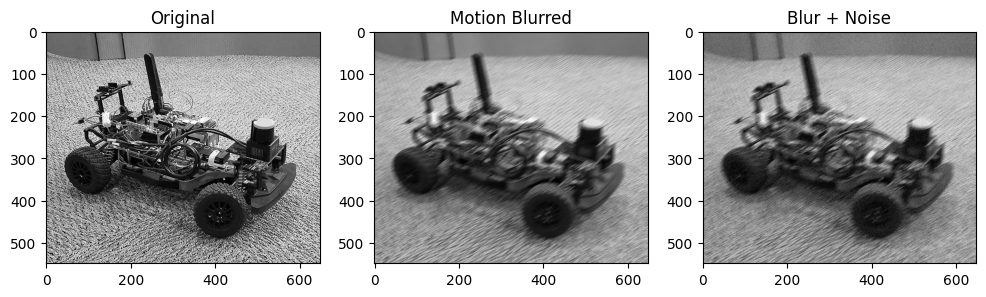

In [ ]:
def motion_blur_kernel(size=15, angle=0):
    kernel = np.zeros((size, size))
    kernel[size//2, :] = np.ones(size)
    kernel = cv2.warpAffine(kernel,
                            cv2.getRotationMatrix2D((size/2-0.5, size/2-0.5), angle, 1.0),
                            (size, size))
    kernel = kernel / np.sum(kernel)
    return kernel


kernel = motion_blur_kernel(size=15, angle=30)
degraded = cv2.filter2D(imgA, -1, kernel)


mean, sigma = 0, 10
noise = np.random.normal(mean, sigma, imgA.shape)
noisy_blurred = np.clip(degraded + noise, 0, 255).astype(np.uint8)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(imgA, cmap='gray'); plt.title("Original")
plt.subplot(1,3,2); plt.imshow(degraded, cmap='gray'); plt.title("Motion Blurred")
plt.subplot(1,3,3); plt.imshow(noisy_blurred, cmap='gray'); plt.title("Blur + Noise")
plt.show()


In [ ]:
def wiener_filter(degraded, kernel, K):

    kernel_padded = np.zeros_like(degraded, dtype=np.float32)
    kh, kw = kernel.shape
    kernel_padded[:kh, :kw] = kernel


    kernel_padded = np.fft.ifftshift(kernel_padded)


    G = np.fft.fft2(degraded)
    H = np.fft.fft2(kernel_padded, s=degraded.shape)


    H_conj = np.conjugate(H)
    Wiener_filter = H_conj / (np.abs(H)**2 + K)

    F_hat = G * Wiener_filter
    f_hat = np.fft.ifft2(F_hat)
    f_hat = np.abs(f_hat)

   ]
    f_hat = np.uint8(np.clip(f_hat, 0, 255))

    return f_hat


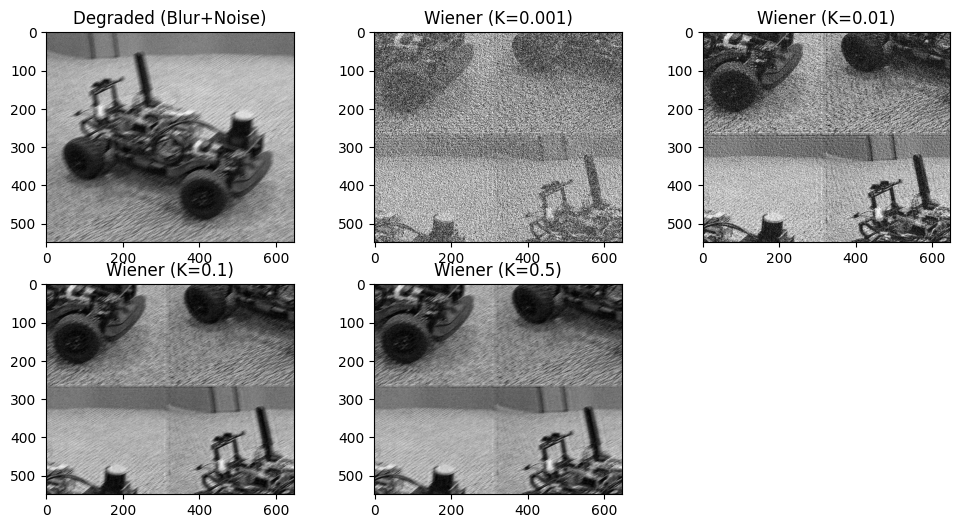

In [ ]:
# Try different noise parameters K
recon1 = wiener_filter(noisy_blurred, kernel, K=0.001)
recon2 = wiener_filter(noisy_blurred, kernel, K=0.01)
recon3 = wiener_filter(noisy_blurred, kernel, K=0.1)

plt.figure(figsize=(12,6))
plt.subplot(2,3,1); plt.imshow(noisy_blurred, cmap='gray'); plt.title("Degraded (Blur+Noise)")
plt.subplot(2,3,2); plt.imshow(recon1, cmap='gray'); plt.title("Wiener (K=0.001)")
plt.subplot(2,3,3); plt.imshow(recon2, cmap='gray'); plt.title("Wiener (K=0.01)")
plt.subplot(2,3,4); plt.imshow(recon3, cmap='gray'); plt.title("Wiener (K=0.1)")
plt.subplot(2,3,5); plt.imshow(recon3, cmap='gray'); plt.title("Wiener (K=0.5)")
plt.show()


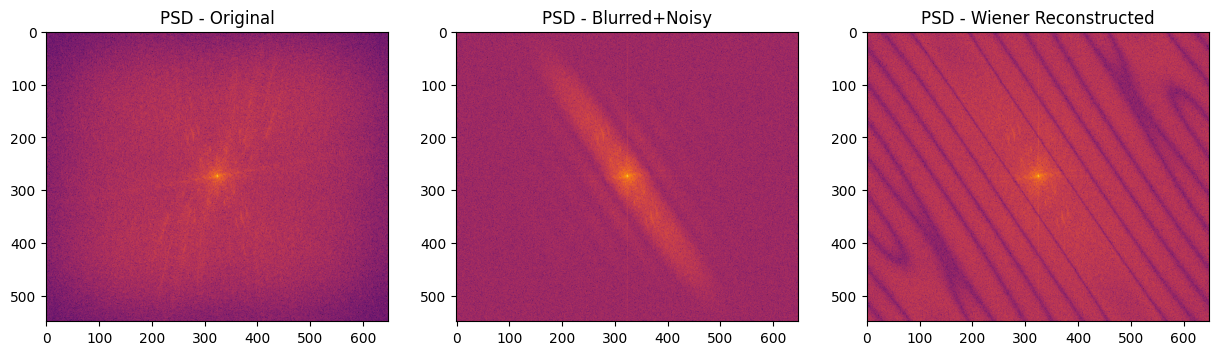

In [ ]:
def compute_psd(image):
 \
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    psd = np.abs(fshift) ** 2

    psd_log = np.log(psd + 1)
    return psd_log


psd_original = compute_psd(imgA)
psd_blurred  = compute_psd(noisy_blurred)
psd_recon    = compute_psd(recon2)


plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(psd_original, cmap='inferno'); plt.title("PSD - Original")
plt.subplot(1,3,2); plt.imshow(psd_blurred, cmap='inferno'); plt.title("PSD - Blurred+Noisy")
plt.subplot(1,3,3); plt.imshow(psd_recon, cmap='inferno'); plt.title("PSD - Wiener Reconstructed")
plt.show()
